In [1]:
import os,sys
current_dir = os.getcwd()
HOME_DIR = current_dir
#Make sure the directory structure is 
DATA_HOME_DIR = current_dir+'/data/redux'

In [2]:
%pwd

u'/home/ubuntu/Fast-AI/lesson2'

In [3]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))
#import modules
from utils import *
from utils.vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [4]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils.utils import plots, get_batches, plot_confusion_matrix, get_data

In [5]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

### Training the model

We start with some basic config steps. We copy a small amount of our data into a 'sample' directory, with the exact same structure as our 'train' directory--this is *always* a good idea in *all* machine learning, since we should do all of our initial testing using a dataset small enough that we never have to wait for it.

In [6]:
path = "data/redux/"
# path = "data/dogscats/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [7]:
# Setting batch size. Trial and error many sizes so that the batch size occupies max size available.
batch_size = 128

In [8]:
# Import Vgg model and initialize
from utils.vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Overall Approach
1. Get the true labels for all images
2. Get the 100 imagenet category predictions for each image
3. Feed these predictions as imput to the dense layer

In [9]:
# Get the training and validation batches
val_batches = get_batches(dirname=path+'valid',shuffle=False,batch_size=batch_size)


Found 2000 images belonging to 2 classes.


In [10]:
batches = get_batches(dirname=path+'train',shuffle=False,batch_size=batch_size)

Found 23000 images belonging to 2 classes.


Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space.

In [11]:
import bcolz
def save_array(fname, arr): c = bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [12]:
#val_data = get_data.get_batches(path+'valid')

In [13]:
#train_data = get_data.get_batches(path+'train')

In [14]:
#save_array(model_path+'train_data.bc',train_data)
#save_array(model_path+'valid_data.bc', val_data)

In [15]:
#val_data = load_array(model_path+'valid_data.bc')

In [16]:
#trn_data = load_array(model_path+'train_data.bc')

In [17]:
# SInce Keras return a single coulumn output, converting them using onehot encoding
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [18]:
val_classes = val_batches.classes
train_classes = batches.classes
val_labels = onehot(val_classes)
train_labels = onehot(train_classes)

In [19]:
train_labels.shape

(23000, 2)

In [20]:
train_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [21]:
train_labels.shape[0]

23000

In [22]:
val_features = model.predict_generator(val_batches,val_labels.shape[0])

In [23]:
train_features = model.predict_generator(batches,train_labels.shape[0])

In [24]:
train_features.shape

(23000, 1000)

In [25]:
save_array(model_path+'train_lastlayer_features.bc', train_features)
save_array(model_path+'valid_lastlayer_features.bc', val_features)

Defining the linear model

In [26]:
lm = Sequential([Dense(2,activation='softmax',input_shape=(1000,))])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
lm.fit(train_features,train_labels,batch_size=batch_size,nb_epoch=6,validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/6
23000/23000 [==============================] - 0s - loss: 0.0718 - acc: 0.9780 - val_loss: 0.0789 - val_acc: 0.9715
Epoch 2/6
23000/23000 [==============================] - 0s - loss: 0.0717 - acc: 0.9781 - val_loss: 0.0794 - val_acc: 0.9720
Epoch 3/6
23000/23000 [==============================] - 0s - loss: 0.0705 - acc: 0.9785 - val_loss: 0.0817 - val_acc: 0.9740
Epoch 4/6
23000/23000 [==============================] - 0s - loss: 0.0700 - acc: 0.9795 - val_loss: 0.0831 - val_acc: 0.9730
Epoch 5/6
23000/23000 [==============================] - 0s - loss: 0.0703 - acc: 0.9801 - val_loss: 0.0856 - val_acc: 0.9740
Epoch 6/6
23000/23000 [==============================] - 0s - loss: 0.0700 - acc: 0.9793 - val_loss: 0.0836 - val_acc: 0.9730


In [28]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we, if anything, we can from these (in general, these are particularly useful for debugging problems in the model; since this model is so simple, there may not be too much to learn at this stage.)

In [43]:
preds = lm.predict_classes(val_features,batch_size=batch_size)
probs = lm.predict_proba(val_features,batch_size=batch_size)[:,0]
print(probs)

1920/2000 [===========================>..] - ETA: 0s[  1.0000e+00   1.0000e+00   1.0000e+00 ...,   6.5012e-05   1.0917e-03   3.9963e-01]


In [44]:
#Get filenames for the batches
filenames = val_batches.filenames

In [45]:
#Setting number of images to visualize for each subset
n_view = 4

In [46]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

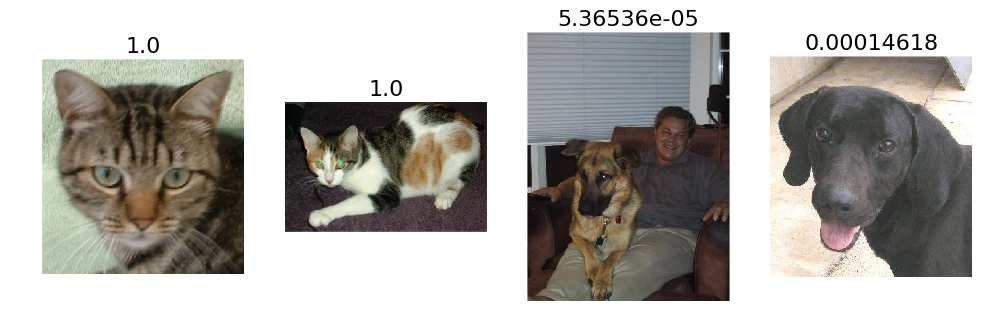

In [48]:
#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

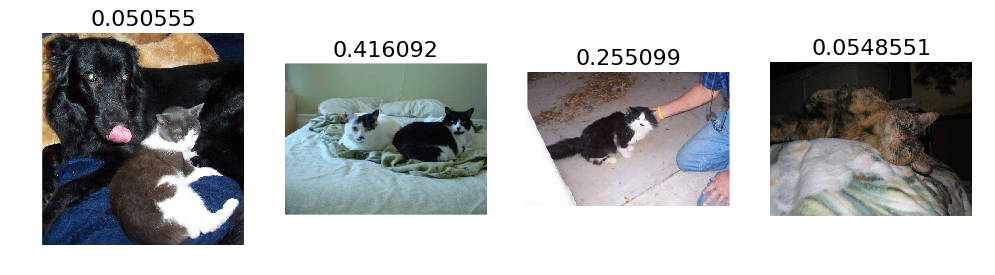

In [49]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

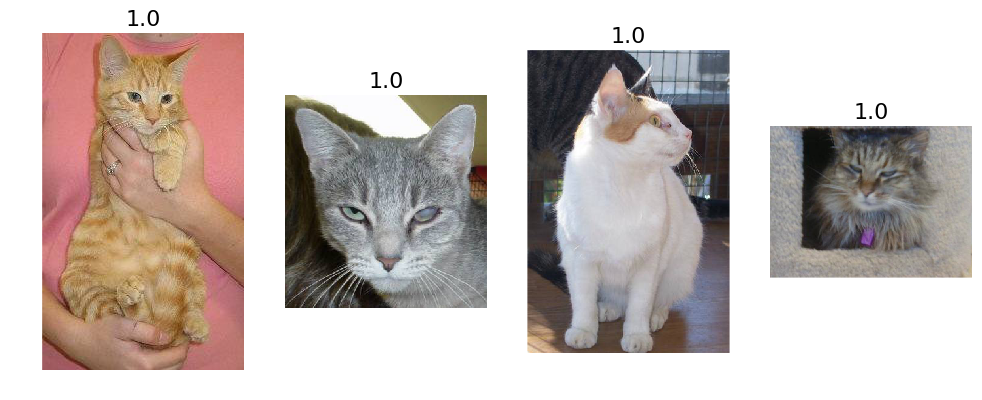

In [50]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

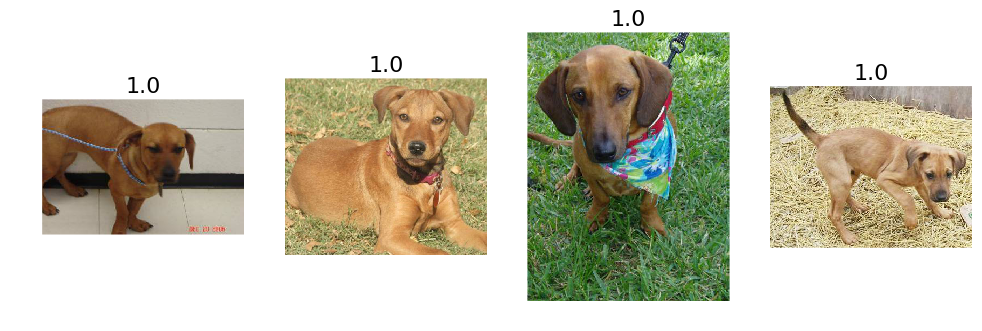

In [51]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])

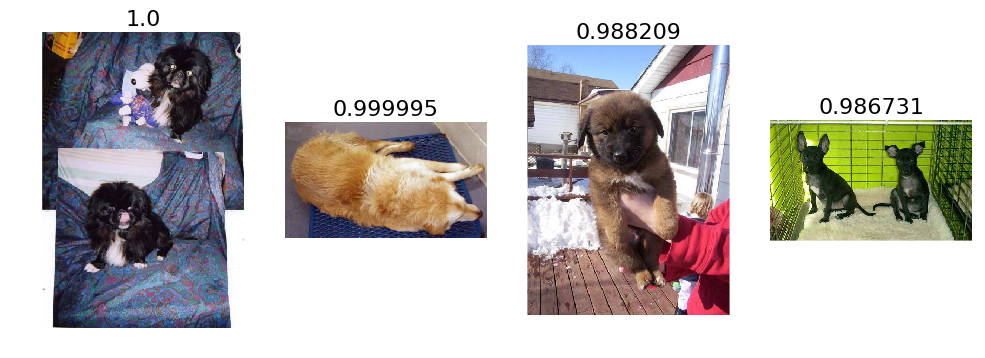

In [52]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
if len(most_incorrect_cats):
    plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])
else:
    print('No incorrect cats!')

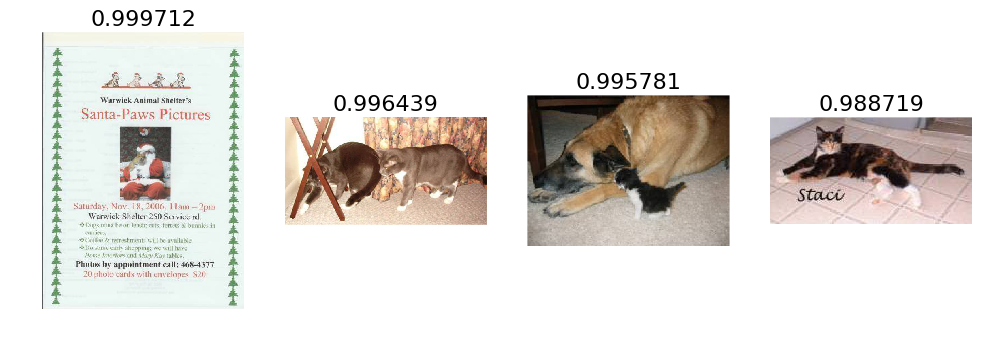

In [53]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
if len(most_incorrect_dogs):
    plots_idx(incorrect_dogs[most_incorrect_dogs], 1-probs[incorrect_dogs][most_incorrect_dogs])
else:
    print('No incorrect dogs!')

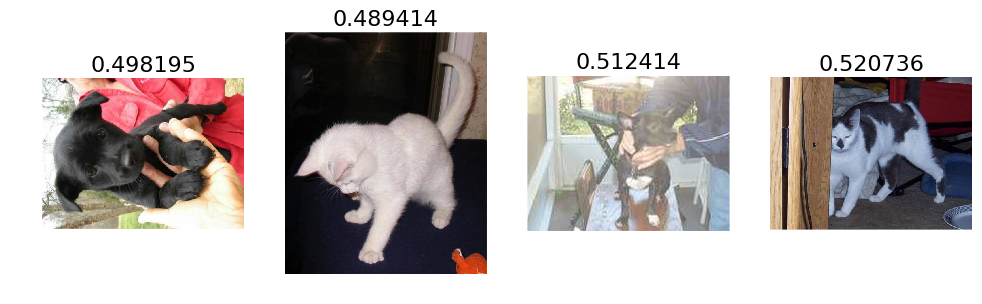

In [54]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

In [55]:
#Using confusion matrix to vaisually analyze the predictions
cm = confusion_matrix(val_classes, preds)

[[958  31]
 [ 23 988]]


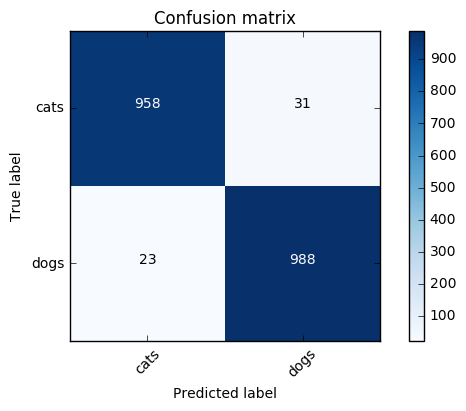

In [56]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [57]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [58]:
model.pop()
for layer in model.layers:
    layer.trainable = False

In [59]:
model.add(Dense(2,activation='softmax'))

In [77]:
gen=image.ImageDataGenerator()
batches = get_batches(dirname=path+'train',shuffle=True,batch_size=batch_size)
val_batches = get_batches(dirname=path+'valid',shuffle=True,batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [78]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=2, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/2
23000/23000 [==============================] - 584s - loss: 0.6157 - acc: 0.9608 - val_loss: 0.6152 - val_acc: 0.9615
Epoch 2/2
23000/23000 [==============================] - 582s - loss: 0.5760 - acc: 0.9635 - val_loss: 0.4773 - val_acc: 0.9700


In [81]:
model.save_weights(model_path+'finetune1.h5')

In [82]:
model.load_weights(model_path+'finetune1.h5')

In [85]:
model.evaluate_generator(val_batches, val_batches.N,verbose=1)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/models.py:908: UserWarning: The "verbose" argument is deprecated.
  warnings.warn('The "verbose" argument is deprecated.')


[0.4289950530529022, 0.97300000047683721]

1920/2000 [===========================>..] - ETA: 0s

In [91]:
val_classes = val_batches.classes
train_classes = batches.classes
val_labels = onehot(val_classes)
train_labels = onehot(train_classes)
val_features=model.predict_generator(val_batches,val_labels.shape[0])
print(val_labels)

In [103]:
val_data = get_data(path+'valid')

Found 2000 images belonging to 2 classes.


In [ ]:
preds = model.predict_classes(val_data,batch_size=batch_size)
probs = model.predict_proba(val_data,batch_size=batch_size)[:,0]

 512/2000 [======>.......................] - ETA: 35s

In [101]:
??model